In [7]:
import numpy as np
import numpy as np
from scipy.linalg.interpolative import interp_decomp
import matplotlib.pyplot as plt

In [8]:
# Use scipy's implementation of the interpolative decomposition
# Instead of the matrix cross interpolation M = C @ P^-1 @ R
# it factorizes as M = A @ P with A = M[:, idx]
def interpolative_decomposition(M, eps_or_k=1e-5, k_min=2):
    r = min(M.shape)
    if r <= k_min:
        k = r
        idx, proj = interp_decomp(M, eps_or_k=k) #eps_or_k = precision of decomposition
    elif isinstance(eps_or_k, int): #checks if eps is an integer
        k = min(r, eps_or_k)
        idx, proj = interp_decomp(M, eps_or_k=k)
    else:
        k, idx,  proj = interp_decomp(M, eps_or_k=eps_or_k)
        if k <= k_min:
            k = min(r, k_min) #is it not enough to put k = k_min? 
                              #r>k_min otherwise first condition would have been true
            idx, proj = interp_decomp(M, eps_or_k=k)
    A = M[:, idx[:k]]
    P = np.concatenate([np.eye(k), proj], axis=1)[:, np.argsort(idx)]
    return A, P, k, idx[:k]

# k is the 'compressed' rank = number of pivot columns
# idx is the array with entries the indeces of the pivot columns
# proj = matrix R s.t. M[:,idx[:k]]*R = M[:,idx[k:]] 
# P = matrix s.t.  M[:,idx[:k]]*P = M (approximated)

Now val defined in this class will be an array of shape (D,) with D number of points in which correlation function is evaluated in space

In [9]:
class function:  # certain function f(x) with x given as binary

    def __init__(self, f):
        self.cache = {}
        self.f = f #store function passed during instantiation


    def __call__(self, *args, **kwds):
        
        if args in self.cache:
            return self.cache[*args]
        else:
            val = self.f(*args)
            self.cache[*args] = val
            return val
    
    def cache_size(self): #size of cache = number of current evaluations
        return len(self.cache) #return the number of entries in the cache

In [37]:
def tensor_cross_interpolation(tensor, func_vals, D, L, d=2, eps_or_chi=1e-6, iters=6):
    #tensor must be function s.t. f(*il,σj,σj+1,*jr).shape = (D,) with D number of points in space
    # random initial choice for index sets
    idxs = np.random.choice(d, size=(L)) #array of L random numbers from 0 to d-1 - index sigma
    As = [None] * L
    I = [idxs[:j].reshape(1, -1) for j in range(L)] # creates list of I_l arrays
    J = [idxs[j:].reshape(1, -1) for j in range(1, L+1)] # list of J_l
    # sweep
    for i in range(iters):
        #print(f'Sweep: {i+1:d}.')
        As, I = left_to_right_sweep(tensor, As, I, J, L, d, D, eps_or_chi)
        As, J = right_to_left_sweep(tensor, As, I, J, L, d, D, eps_or_chi)
    #in theory, at the end of these sweeps the first tensor of As should be the only one with the additional leg of dim D

    func_interp = np.squeeze(As[0]) #removes any singleton dimensions (dimensions of size 1).
    # we now have func_interp.shape = (d,chir,D)

    func_interp = np.squeeze(As[-1]) #now has two legs: ab
    for A in As[-2:0:-1]:
        func_interp = np.einsum('idk, kj -> idj', A, func_interp)
        func_interp = func_interp.reshape(A.shape[0], -1)
    if As[0].shape[3] == D:
        func_interp = np.einsum('akd, kj -> ajd', np.squeeze(As[0]), func_interp)
        func_interp = np.transpose(func_interp, [2,0,1])
        func_interp = func_interp.reshape(-1, D)
    else: 
        return print("Error")

    difference = func_vals-func_interp #should be difference between 2 matrices
    err_max = np.max(np.abs(difference))/np.max(np.abs(func_vals))
    err_2 = np.linalg.norm(difference)/np.linalg.norm(func_vals)
    evals = tensor.cache_size() * D

    return As, J, evals, err_2, err_max, func_interp

def left_to_right_sweep(tensor, As, I, J, L, d, D, eps_or_chi):
    # sweep left to right
    for bond in range(L-1):
        # construct local two-site tensor
        chil, _ = I[bond].shape #chil = number of rows in array I_l: number of combinations (σ1,..,σl)
        chir, _ = J[bond+1].shape #which corresponds to number of "points" on which I am evaluating function
        
        Pi = np.zeros((D, chil, d, d, chir))
        for il in range(chil):
            for s1 in range(d):
                for s2 in range(d):
                    for jr in range(chir):
                        val = tensor(*I[bond][il,:],s1,s2,*J[bond+1][jr,:])
                        Pi[:,il,s1,s2,jr] = val
        Pi = np.transpose(Pi, [1,2,3,4,0])
        Pi = Pi.reshape(chil * d, d * chir * D)
        # decompose using interpolative decomposition:
        # Pi = P^T @ A^T, A^T = Pi[idx,:]
        A, P, k, idx = interpolative_decomposition(Pi.T, eps_or_k=eps_or_chi)
        # update indices using idxs c I[bond] x {0, 1, ..., d-1}
        I[bond+1] = np.array([np.append(I[bond][i//d], [i%d]) for i in idx])
        # update tensors
        As[bond] = P.T.reshape(chil, d, k)
        As[bond+1] = A.T.reshape(k, d, chir, D)
    return As, I

def right_to_left_sweep(tensor, As, I, J, L, d, D, eps_or_chi):
    # sweep right to left
    for bond in range(L-2,-1,-1):
        # construct local two-site tensor
        chil, _ = I[bond].shape
        chir, _ = J[bond+1].shape

        Pi = np.zeros((D, chil, d, d, chir))
        for il in range(chil):
            for s1 in range(d):
                for s2 in range(d):
                    for jr in range(chir):
                        val = tensor(*I[bond][il,:],s1,s2,*J[bond+1][jr,:])
                        Pi[:,il,s1,s2,jr] = val
        Pi = Pi.reshape(D * chil * d, d * chir)
        # decompose using interpolative decomposition:
        # Pi = A @ P, A = Pi[:,idx]
        A, P, k, idx = interpolative_decomposition(Pi, eps_or_k=eps_or_chi)
        # update indices using idxs c {0, 1, ..., d-1} x J[bond+1]
        J[bond] = np.array([np.append([i//chir], J[bond+1][i%chir]) for i in idx])
        # update tensors
        As[bond] = A.reshape(chil, d, k, D)
        As[bond+1] = P.reshape(k, d, chir)
    return As, J

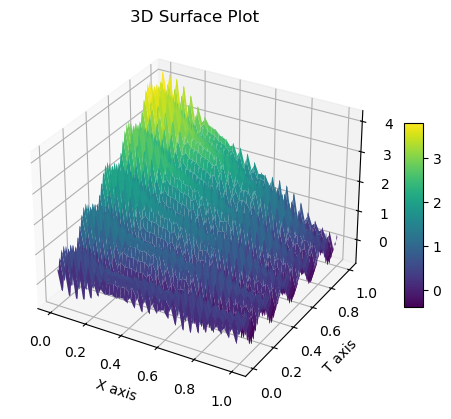

In [ ]:
# Example: create a function to interpolate
test_func = lambda x, t: 0.4 * np.sin(10 * np.pi * t)\
                    + 0.1 * np.cos(99 * np.pi * t)\
                    + 0.3 * np.cos(50 * np.pi * x)\
                    + 0.2 * np.sin(250 * np.pi * x)\
                    + 4 * t * (1 - x)\


# exact function values
n = 10
ts = np.linspace(0, 1, 2**n, endpoint=False)
D = 50
xs = np.linspace(0,1,D)
X, T = np.meshgrid(xs, ts)
func_vals = test_func(X,T)
#print(type(func_vals))
# Works the same as with a regular function

#print(func_vals.shape[0])
#print(func_vals.shape[1]) = D

# Create a figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, T, func_vals, cmap='viridis', edgecolor='none')

# Add labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('T axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Surface Plot')

# Add color bar
fig.colorbar(surf, shrink=0.5, aspect=10)

# Show the plot
plt.show()

In [50]:
#first we define the function f(t)
# which returns the slice of func_vals along x for a specific time 
f_t = lambda *t: func_vals.reshape((D,) + (2,) * n)[:,*t]
#here we have to define func as the initialization of the class
func = function(f_t)
print(func(0,1,1,0,0,0,0,0,0,0).shape)
As, _, eval, err_2, err_max, func_interp = tensor_cross_interpolation(func,         # function to be interpolated
                                   func_vals,    
                                   D,
                                   L=n,          # number of MPS tensors
                                   eps_or_chi=20, # bond dimension
                                   iters=4)       # number of back-and-forth sweeps

print(np.linalg.norm(func_vals), np.max(np.abs(func_vals)))


(50,)
312.20049458472016 4.247585285382157


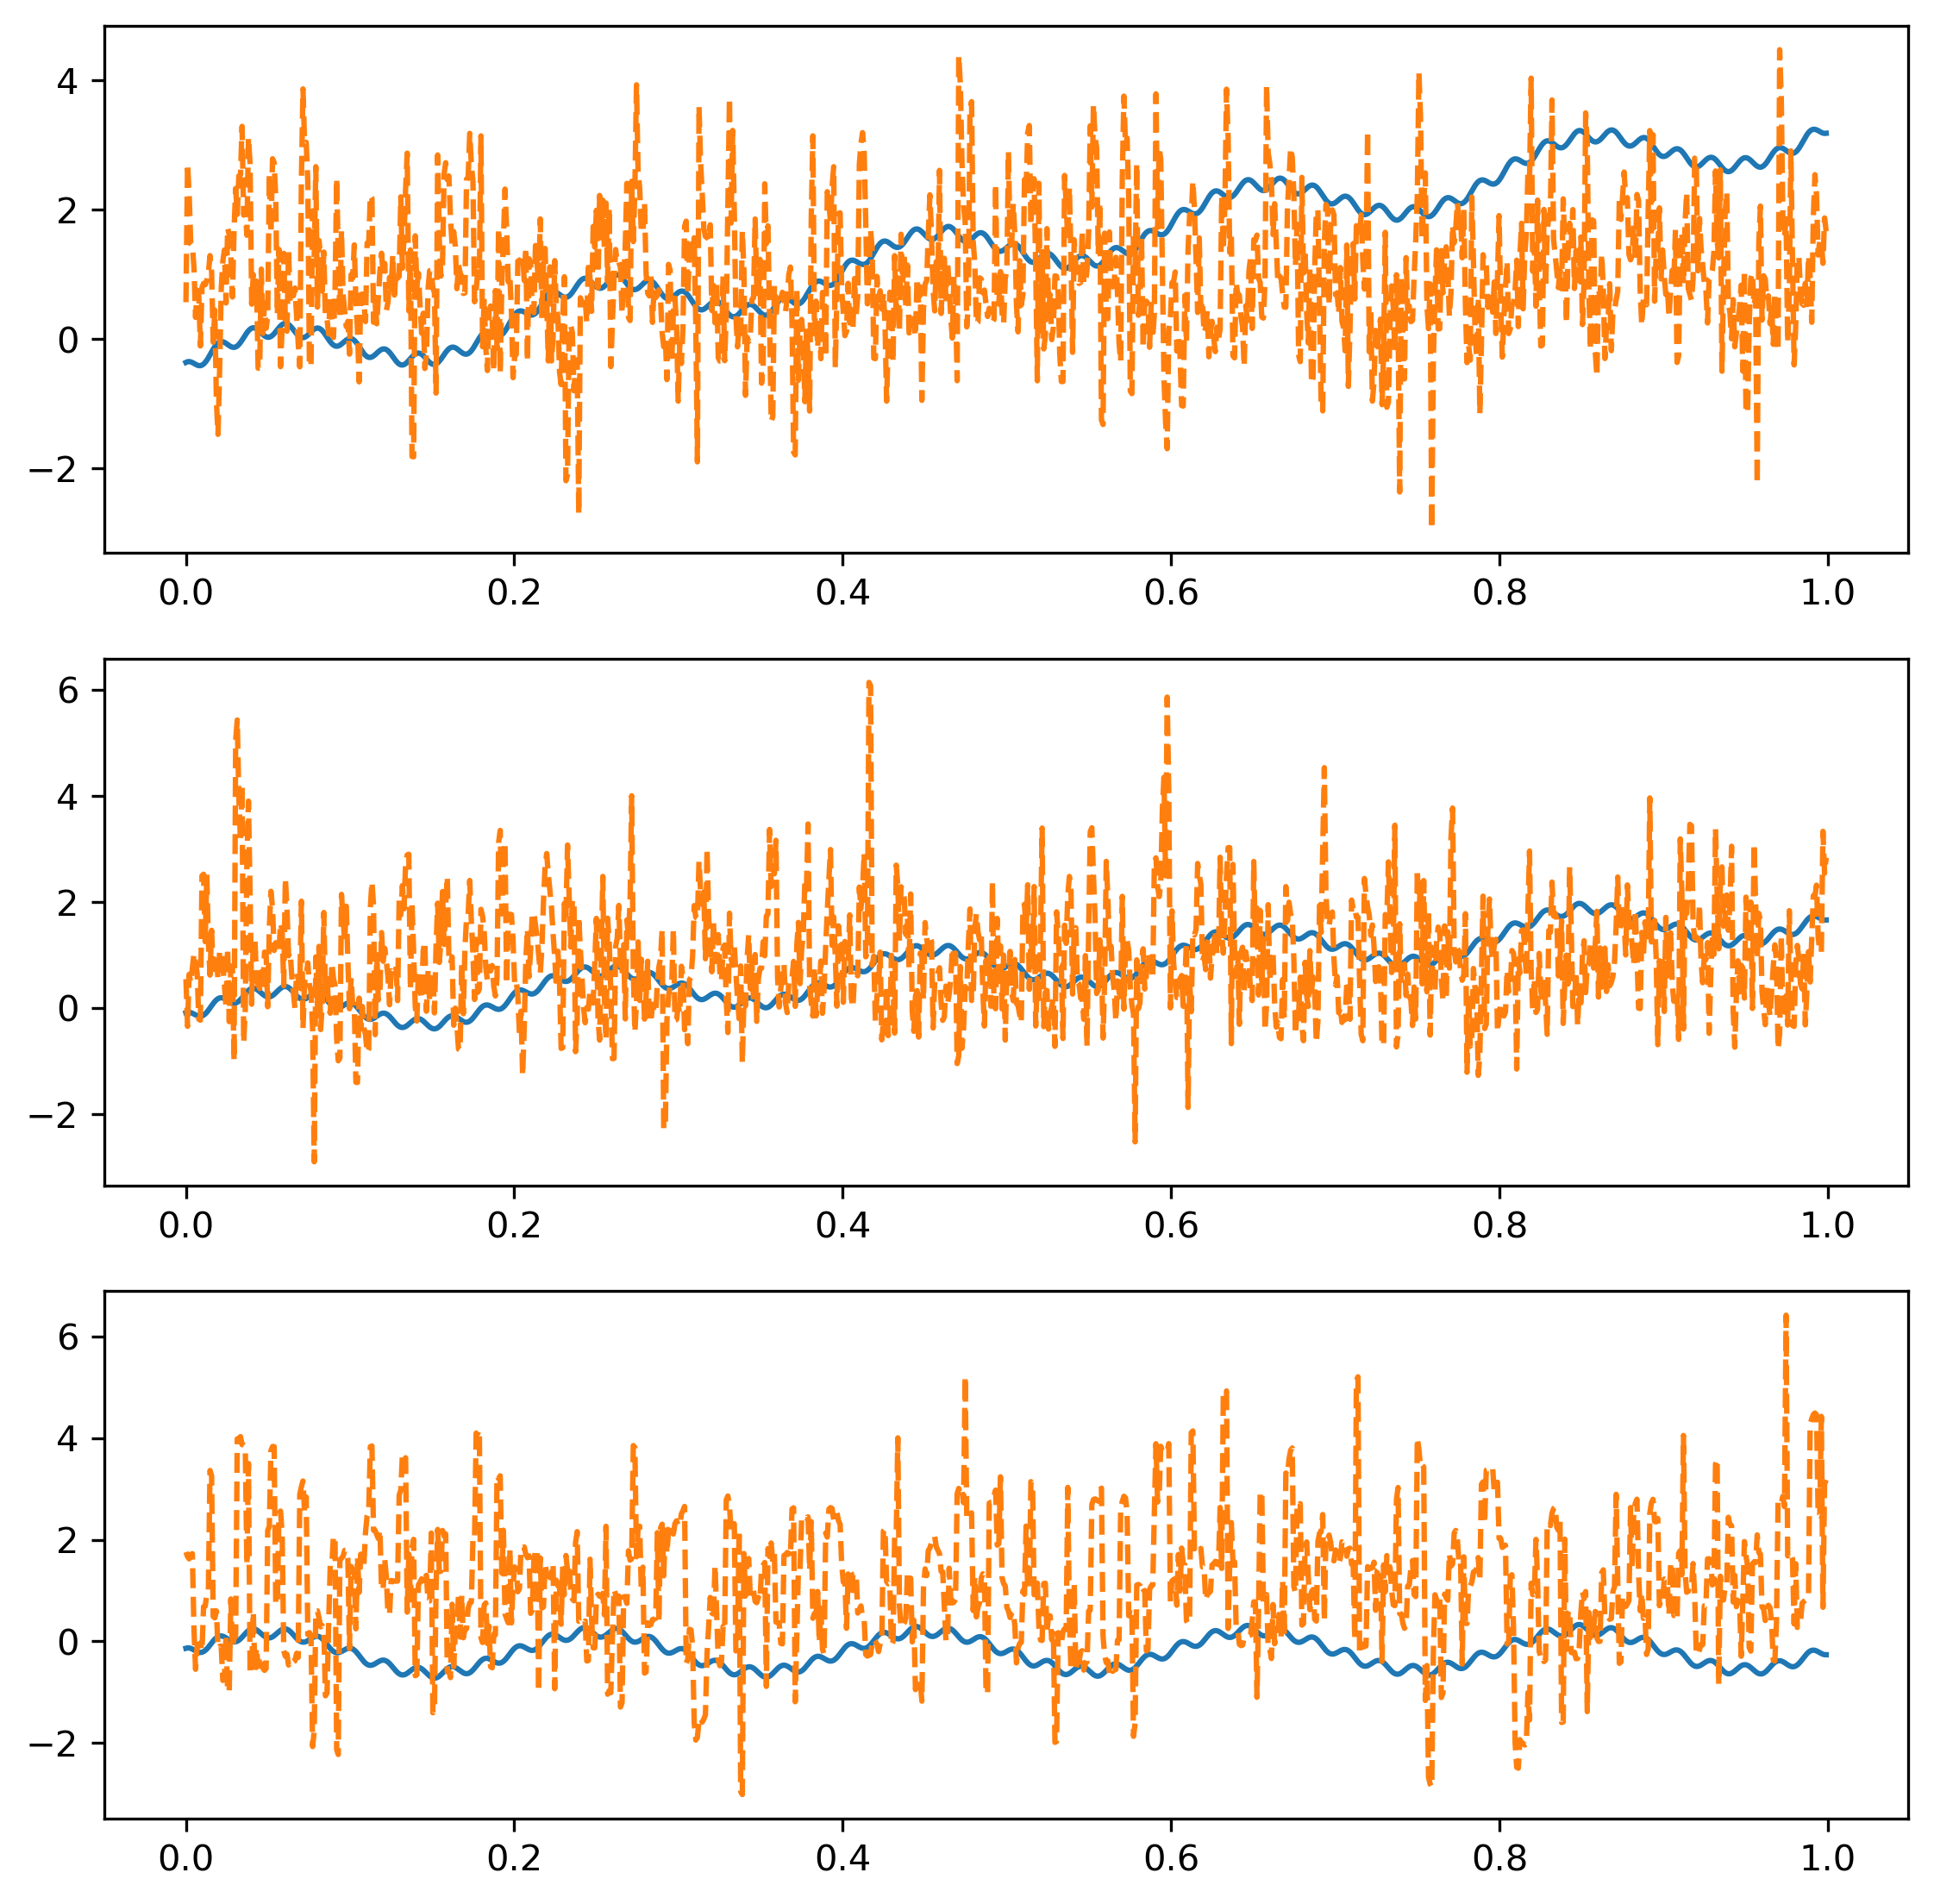

In [45]:
fig, axs = plt.subplots(nrows=3, figsize=(9,9), dpi=300)

for i,item in enumerate([3, D//2, D-2]):
    axs[i].plot(ts, func_vals[:,item], '-')
    axs[i].plot(ts, func_interp[:,item], '--')

plt.show()

In [ ]:
func = function(lambda *x: func_vals.reshape((2,) * 10)[*x])

def f_t_index_binary(digits):
    # Convert the binary list of digits into a valid index
    t_index = sum(d * (2 ** idx) for idx, d in enumerate(reversed(digits)))  # binary to index conversion
    # Return the row corresponding to the t_index (an array of all x values)
    return func_vals[t_index, :]